In [2]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
#import soundfile as sf
import os
import numpy as np
from PIL import Image
from scipy.fftpack import fft
import os
import wave
import pylab
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
import time
from sklearn.feature_extraction import DictVectorizer
from torch.utils.data.dataset import Dataset
from sklearn.pipeline import Pipeline
from collections import defaultdict
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
 

use_cuda = torch.cuda.is_available()

%matplotlib inline



audio_path = '/Users/mahimaparashar/Desktop/GradSchool/filler_word_detection/filler_word/data/audio/'
pict_Path = '/Users/mahimaparashar/Desktop/GradSchool/filler_word_detection/filler_word/data/'
test_pict_Path = '../input/picts/test/'
test_audio_path = '../input/test/audio/'
IMG_DATA_LABELS = pict_Path + '/train_v2.csv'
IMG_EXT = '.png'

In [3]:
def graph_spectrogram(wav_file):
    sound_info, frame_rate = get_wav_info(wav_file)
#     pylab.figure(num=None, figsize=(19, 12))
    pylab.subplot(111)
    pylab.title('spectrogram of %r' % wav_file)
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.savefig(wav_file + '.png')


def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, 'Int16')
    frame_rate = wav.getframerate()
    wav.close()
    
    return sound_info, frame_rate


/Users/mahimaparashar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  del sys.path[0]
/Users/mahimaparashar/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


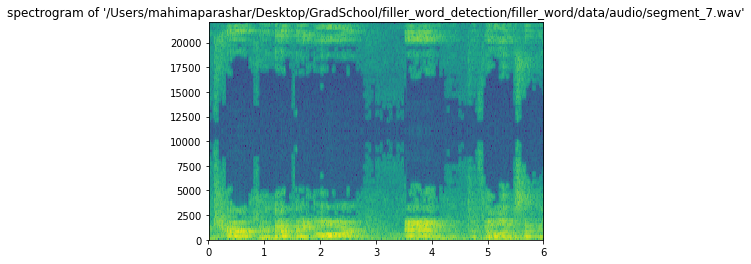

In [4]:
file_names = np.empty((16308), dtype = 'object')
labels = np.zeros(16308)
ind = 0

for file in os.listdir(audio_path):
    if file.endswith(".wav"):
        wav_file = audio_path + file
        graph_spectrogram(wav_file)
        with open(wav_file[:-4] + "_label.txt") as label_file:
            label = label_file.read()
        if label:
            labels[ind] = 1
        
        ind += 1

In [11]:
d = defaultdict(LabelEncoder)
columns = ['img', 'label-str','full_path']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)

for file in os.listdir(audio_path):
    if file.endswith(".png"):
        fullpath = audio_path + file
        with open(audio_path + file[:-8] + "_label.txt") as label_file:
            label = label_file.read()
        if label:
            l = 1.0
        else:
            l = 0.0
        df_pred = df_pred.append({'img': file, 'label-str': l, 'full_path': fullpath}, ignore_index = True)
        df_pred['label'] = LabelEncoder().fit_transform(df_pred['label-str'])
    
df_pred.to_csv(IMG_DATA_LABELS, columns=('img','label-str','full_path', 'label'), index=None, header=False)


df_pred.head(10)

,img,label-str,full_path,label
0,segment_8.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
1,segment_1.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
2,segment_10.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
3,segment_9.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
4,segment_6.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
5,segment_7.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
6,segment_2_0.wav.png,1.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,1
7,segment_5.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
8,segment_4.wav.png,0.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,0
9,segment_3_0.wav.png,1.0,/Users/mahimaparashar/Desktop/GradSchool/fille...,1


In [79]:
class GenericImageDataset(Dataset):    

    def __init__(self, csv_path, img_path, img_ext, transform=None):
        
        t = time.time()        
#         lgr.info('CSV path {}'.format(csv_path))
#         lgr.info('IMG path {}'.format(img_path))        
        
        assert img_ext in ['.png']
        
        tmp_df = pd.read_csv(csv_path, header=None) # img,label,fullpath
                        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform
             
        self.X_train = tmp_df[2]        
        
        self.y_train = self.mlb.fit_transform(tmp_df[1].apply(str).str.split()).astype(np.float32) 
        print self.y_train
        self.y_train= self.y_train.reshape((self.y_train.shape[0]*2,1)) # Must be reshaped for PyTorch! 
        print self.y_train
        
        
    def __getitem__(self, index):
        path=self.img_path + self.X_train[index]
        path=self.X_train[index]
        img = Image.open(path)
        img = img.convert('RGB')
        if self.transform is not None: # TypeError: batch must contain tensors, numbers, or lists; 
                                     #found <class 'PIL.Image.Image'>
            img = self.transform(img)
        label = (self.y_train[index])
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
#         lgr.info ("Lenght:" +str(l))
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0    

In [80]:
transformations = transforms.Compose([transforms.ToTensor()])
dset_train = GenericImageDataset(IMG_DATA_LABELS,audio_path,IMG_EXT,transformations)

# for i in range(10):
#     sample=dset_train[i]
#     print(sample[0].shape)
#     print(sample[1])
#     print(sample[2])
     

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]
[[ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]
 [ 1.]]


In [81]:
batch_size = 16 # on GTX 1080
global_epoches = 10
LR = 0.0005
MOMENTUM = 0.95
validationRatio=0.11    

class FullTrainningDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainningDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    


def trainTestSplit(dataset, val_share=validationRatio):
    val_offset = int(len(dataset)*(1-val_share))
    print("Offest:" + str(val_offset))
    return FullTrainningDataset(dataset, 0, val_offset), FullTrainningDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print(train_loader)
print(val_loader)

Offest:8


In [82]:
dropout = torch.nn.Dropout(p=0.30)
class ConvRes(nn.Module):
    def __init__(self, insize, outsize):
        super(ConvRes, self).__init__()
        drate = .3
        self.math = nn.Sequential(
            nn.BatchNorm2d(insize),
            # nn.Dropout(drate),
            torch.nn.Conv2d(insize, outsize, kernel_size=2, padding=2),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.math(x)


class ConvCNN(nn.Module):
    def __init__(self, insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
        super(ConvCNN, self).__init__()
        self.avg = avg
        self.math = torch.nn.Sequential(
            torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(outsize),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(pool, pool),
        )
        self.avgpool = torch.nn.AvgPool2d(pool, pool)

    def forward(self, x):
        x = self.math(x)
        if self.avg is True:
            x = self.avgpool(x)
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.cnn1 = ConvCNN(3, 32, kernel_size=7, pool=4, avg=False)
        self.cnn2 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)

        self.res1 = ConvRes(32, 64)

        self.features = nn.Sequential(
            self.cnn1, dropout,
            self.cnn2,
            self.cnn3,
            self.res1,
        )

        self.classifier = torch.nn.Sequential(
            nn.Linear(3136, 1),
        )
        self.sig = nn.Sigmoid()
  
    def forward(self, x):
        x = self.features(x)
#         print (x.data.shape)
        x = x.view(x.size(0), -1)
#         print (x.data.shape)
        x = self.classifier(x)
#         print (x.data.shape)
        x = self.sig(x)
        return x

    
if use_cuda:
#     lgr.info ("Using the GPU")
    model = Net().cuda() # On GPU
else:
#     lgr.info ("Using the CPU")
    model = Net() # On CPU

# lgr.info('Model {}'.format(model))

loss_func=torch.nn.BCELoss()
loss_func = nn.MultiLabelSoftMarginLoss()
# loss_func = torch.nn.CrossEntropyLoss()
# NN params
LR = 0.005
MOMENTUM= 0.9
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=5e-5) #  L2 regularization
if use_cuda:
    lgr.info ("Using the GPU")    
    model.cuda()
    loss_func.cuda()

In [83]:
class CNNClassifier(nn.Module):
    """Custom module for a simple convnet classifier"""
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(144900, 2000)
        self.fc2 = nn.Linear(2000, 50)
        self.fc3 = nn.Linear(50,2)
     
    def forward(self, x):
        print x.shape
        # input is 28x28x1
        # conv1(kernel=5, filters=10) 28x28x10 -> 24x24x10
        # max_pool(kernel=2) 24x24x10 -> 12x12x10
         
        # Do not be afraid of F's - those are just functional wrappers for modules form nn package
        # Please, see for yourself - http://pytorch.org/docs/_modules/torch/nn/functional.html
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
         
        # conv2(kernel=5, filters=20) 12x12x20 -> 8x8x20
        # max_pool(kernel=2) 8x8x20 -> 4x4x20
        x = F.relu(F.max_pool2d(self.dropout(self.conv2(x)), 2))
         
        # flatten 4x4x20 = 320
        print x.shape
        x = x.view(-1, 144900)
         
        # 320 -> 50
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
         
        # 50 -> 10
        x = self.fc2(x)
         
        # transform to logits
        return F.log_softmax(x)

    # create classifier and optimizer objects
clf = CNNClassifier()
opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.5)
 
loss_history = []
acc_history = []

def train(epoch):
    clf.train() # set model in training mode (need this because of dropout)
     
    # dataset API gives us pythonic batching 
    for batch_id, (data, label) in enumerate(train_loader):
        data = Variable(data)
        target = Variable(label).long()

        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = clf(data)
        loss = F.nll_loss(preds, target)
        loss.backward()
        loss_history.append(loss.data[0])
        opt.step()
         
        if batch_id % 100 == 0:
            print(loss.data[0])

def test(epoch):
    clf.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0
     
    for data, target in test_loader:
        data = Variable(data, volatile=True) 
        target = Variable(target)
         
        output = clf(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
 
    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = 100. * correct / len(test_loader.dataset)
    acc_history.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

for epoch in range(0, 3):
    print("Epoch %d" % epoch)
    train(epoch)
    test(epoch)

Epoch 0
torch.Size([8, 3, 288, 432])
torch.Size([8, 20, 69, 105])


/Users/mahimaparashar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


RuntimeError: multi-target not supported at /Users/soumith/minicondabuild3/conda-bld/pytorch_1518371252923/work/torch/lib/THNN/generic/ClassNLLCriterion.c:22